# A look at coastal along-track data #

Along-track data with some altimetry measurements and corrections plus flags are available. 

<br>made for Aviso by CLS

** Import libraries **

In [1]:
import os
from datetime import datetime
import numpy as np
import glob
# reading / using NetCDF data
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs

load one file

In [2]:
# upload one file and look at its contents
input_root = 'data/'
input_path = ''
input_file = 'dt_coastal_j3_phy_20hz_20201201_20230921.nc'
my_file = os.path.join(input_root,input_path,input_file)
nc = xr.open_dataset(my_file)

for variable in nc.variables.keys():
    print(variable)

time
cycle
track
longitude
latitude
longitude_theoretical
latitude_theoretical
distance_from_theoretical
distance_from_coast
sea_level_anomaly
validation_flag
dac
ib_lf
internal_tide
mdt
ocean_tide
load_tide
swh
wind_speed
inter_mission_bias


Those variables are of different nature:
- dimensions / coordinates: longitude, latitude, time (with alternate longitude_theoretical, latitude_theoretical, which enable to locate a point in a track at the same exact point from one cycle to the following)
- cycle, track
- altimeter-derived variable: sea_level_anomaly, swh, wind_speed
- corrections (already applied, but here to be able to change them): dac, ib_lf, internal_tide, ocean_tide, load_tide
- a reference surface: mdt (NB. absolute dynamic topography = sea_level_anomaly + mdt)
- distance_from_coast
- distance_from_theoretical (distance between the real measurement location and the theoretical one)
- validation: validation_flag, inter_mission_bias

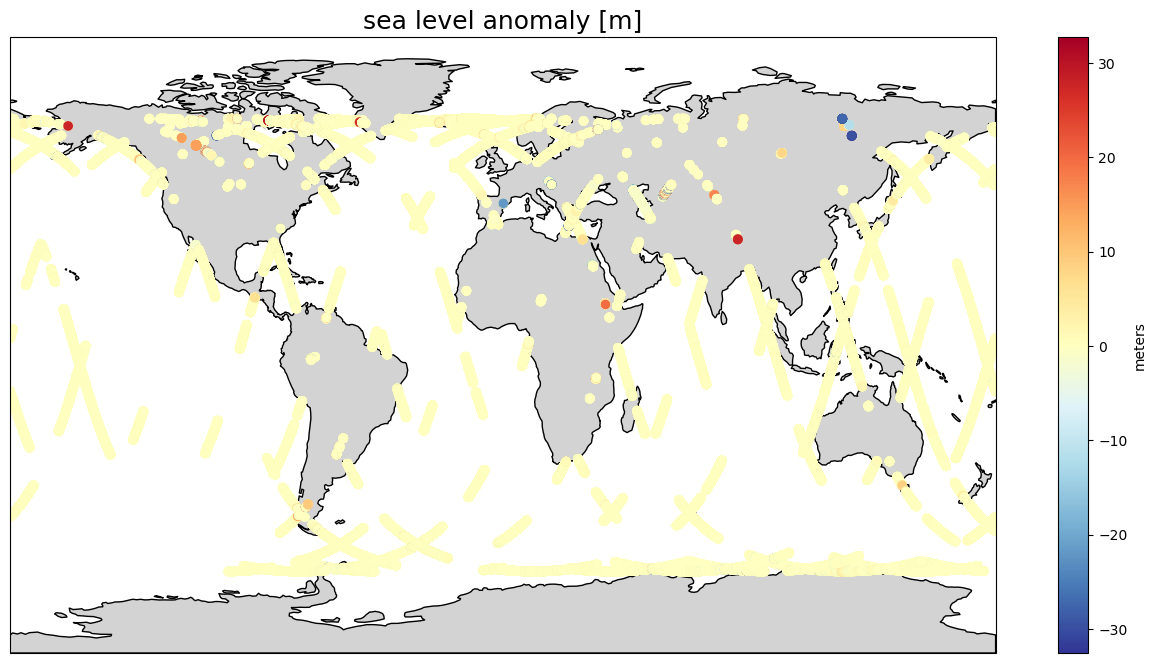

In [3]:
# map the data just to see where we have them in the one selected file, and the amplitude of the variable sea_level_anomaly
lat = nc['latitude']
lon = nc['longitude']
sla = nc['sea_level_anomaly']

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# actually plot the data
tracks = ax.scatter(lon, lat,  c=sla, cmap='RdYlBu_r', marker='o')
cbar = plt.colorbar(tracks)
cbar.set_label('meters')
plt.title('sea level anomaly [m]', size=18)
plt.show()


** Use of the "validation" flag **

You see on the map above that most points are not far from 0 m, but a few are on lands and/or have very high values. The validation flag is there to remove spurious points. 

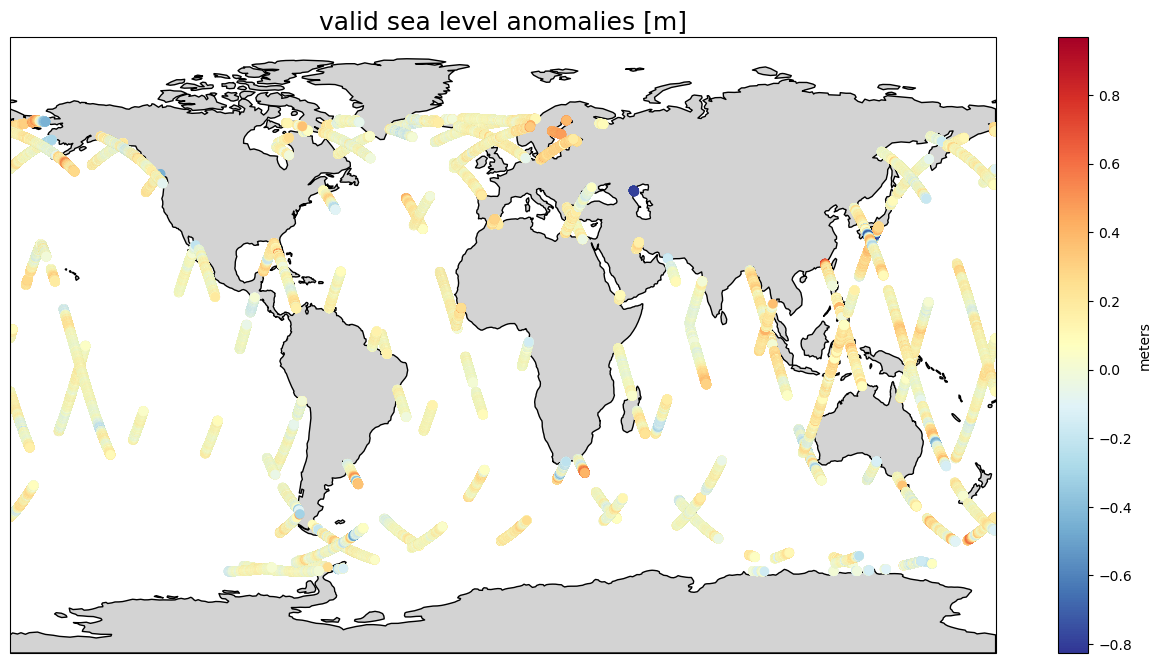

In [4]:
validation_flag = nc['validation_flag']
nc_valid = nc.sel(time=(validation_flag==0))

sla_valid = nc_valid['sea_level_anomaly']
lon_valid = nc_valid['longitude']
lat_valid = nc_valid['latitude']

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# actually plot the data
tracks = ax.scatter(lon_valid, lat_valid,  c=sla_valid, cmap='RdYlBu_r', marker='o')
cbar = plt.colorbar(tracks)
cbar.set_label('meters')
plt.title('valid sea level anomalies [m]', size=18)
plt.show()

The values are much more in line with what you can expect as sea level anomalies. 

Load a complete month (as an example - note that it is a bit "long" (several minutes) ; need dask to be installed even if it is not called directly)

In [5]:
# the data for December 2020 (and only them) were stored within a dedicated folder for the demonstration
# if a full year or more was there, it would be the same instruction (not the same folder name). 
input_path = '2020_12/'
coastal_files = glob.glob(os.path.join(input_root,input_path,'dt_coastal_j3_phy_20hz_202012*_20230921.nc'))
J3month = xr.open_mfdataset(coastal_files, combine='nested', concat_dim='time', compat='no_conflicts')

# variables used in next cells.
validation_flag = J3month['validation_flag']
J3month_valid = J3month.sel(time=(validation_flag==0))
time = J3month_valid['time']

look at the created xarray dataset. It has time as dimension (which means you have the whole month of data within the xarray dataset in memory)

In [6]:
J3month

<xarray.Dataset>
Dimensions:                    (time: 18167653)
Coordinates:
  * time                       (time) datetime64[ns] 2020-12-01T00:00:00.0156...
    longitude                  (time) float64 dask.array<chunksize=(1023,), meta=np.ndarray>
    latitude                   (time) float64 dask.array<chunksize=(1023,), meta=np.ndarray>
Data variables: (12/17)
    cycle                      (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    track                      (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    longitude_theoretical      (time) float64 dask.array<chunksize=(1023,), meta=np.ndarray>
    latitude_theoretical       (time) float64 dask.array<chunksize=(1023,), meta=np.ndarray>
    distance_from_theoretical  (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    distance_from_coast        (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    ...                         ...
    mdt                        (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    ocean_tide                 (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    load_tide                  (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    swh                        (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    wind_speed                 (time) float32 dask.array<chunksize=(2042,), meta=np.ndarray>
    inter_mission_bias         (time) float32 0.68 0.68 0.68 ... 0.68 0.68 0.68
Attributes: (12/41)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_url:                     www.aviso.altimetry.fr
    geospatial_lat_resolution:       5.19999999966103e-05
    ...                              ...
    time_coverage_end:               2020-12-01T23:59:59Z
    time_coverage_duration:          P23H59M59S
    date_created:                    2023-09-21T23:43:37Z
    date_issued:                     2023-09-21T23:43:37Z
    date_modified:                   2023-09-21T23:43:37Z
    history:                         2023-09-21T23:43:37Z: Creation

Select a period within that aggregated dataset. Note that time is the dimension of the whole dataset.

In [7]:
#define one date format we will use for start and end date of our period
format = '%Y-%m-%dT%H:%M:%S'
# start and end date of our period, in a datetime format (to be able to compare them with the time variable of the files)
firstdate = datetime.strptime('2020-12-07T00:00:00', format)
lastdate = datetime.strptime('2020-12-17T00:00:00', format)
# select the period withing the aggregated dataset.
subsetperiod = J3month_valid.sel(time=slice(firstdate, lastdate))
#look at the resulting dataset
subsetperiod

<xarray.Dataset>
Dimensions:                    (time: 4697811)
Coordinates:
  * time                       (time) datetime64[ns] 2020-12-07T00:21:08.5053...
    longitude                  (time) float64 dask.array<chunksize=(889,), meta=np.ndarray>
    latitude                   (time) float64 dask.array<chunksize=(889,), meta=np.ndarray>
Data variables: (12/17)
    cycle                      (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    track                      (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    longitude_theoretical      (time) float64 dask.array<chunksize=(889,), meta=np.ndarray>
    latitude_theoretical       (time) float64 dask.array<chunksize=(889,), meta=np.ndarray>
    distance_from_theoretical  (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    distance_from_coast        (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    ...                         ...
    mdt                        (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    ocean_tide                 (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    load_tide                  (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    swh                        (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    wind_speed                 (time) float32 dask.array<chunksize=(1871,), meta=np.ndarray>
    inter_mission_bias         (time) float32 0.68 0.68 0.68 ... 0.68 0.68 0.68
Attributes: (12/41)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_url:                     www.aviso.altimetry.fr
    geospatial_lat_resolution:       5.19999999966103e-05
    ...                              ...
    time_coverage_end:               2020-12-01T23:59:59Z
    time_coverage_duration:          P23H59M59S
    date_created:                    2023-09-21T23:43:37Z
    date_issued:                     2023-09-21T23:43:37Z
    date_modified:                   2023-09-21T23:43:37Z
    history:                         2023-09-21T23:43:37Z: Creation

Select an area using a longitude/latitude box, taking back the full month dataset for further demonstrations.
Neither longitude nor latitude are dimensions (only coordinates), so the expression is different from the above one for time selection.

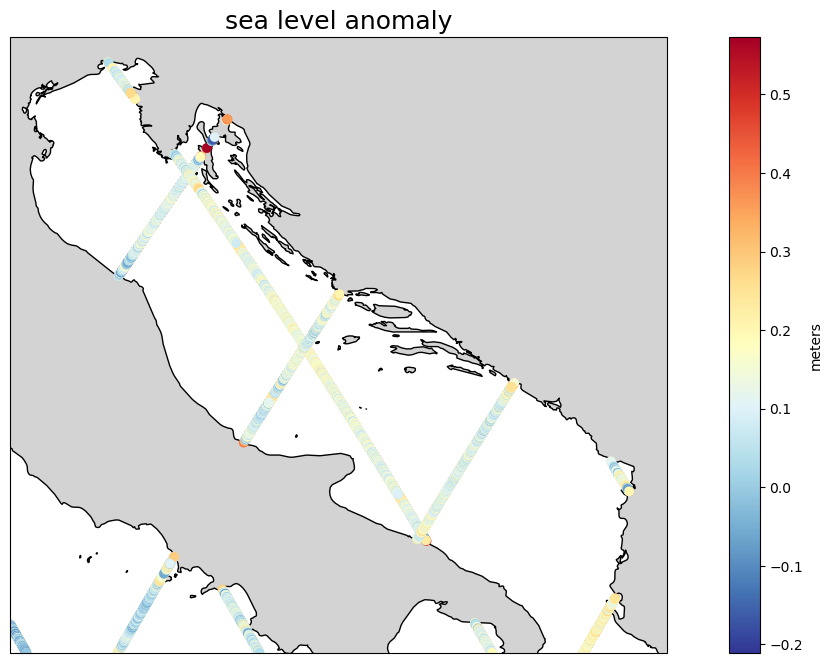

In [8]:
#Adriatic longitude as defined in the data: 0-360
lon_min = 12; lat_min = 40; lon_max= 20; lat_max = 46;

#we need longitude and latitude from the data for the selection
longitude = J3month_valid['longitude']
latitude = J3month_valid['latitude']

#!!! beware that if lon = 0 is included within your box, you'll need to proceed in two different selections, one on [-180,0], 
# the other on [0,180] then merge them.
subsetArea = J3month_valid.sel(time=((longitude > lon_min) & (longitude < lon_max) & (latitude > lat_min) & (latitude < lat_max)))

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
# notice that lon_min and lon_max are expressed in [-180,180] here
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)

# plot the data on a map (sea level anomaly, but we could also plot 'swh')
tracks = ax.scatter(subsetArea['longitude'], subsetArea['latitude'], c=subsetArea['sea_level_anomaly'], cmap='RdYlBu_r', marker='o')
cbar = plt.colorbar(tracks)
cbar.set_label('meters')
plt.title('sea level anomaly', size=18)
plt.show()

# save the resulting selection in a netcdf file for further use.
subsetArea.to_netcdf('selectArea_1month.nc')

Select only the variables you need, and save the file.

In [9]:
#if we are only interested in sea level anomalies and corrections, and have already applied the validation_flag, we can remove them from the dataset
subsetAreaVarused = subsetArea.drop_vars(["wind_speed", "swh", "validation_flag"])
# save the resulting selection in a netcdf file for further use.
subsetAreaVarused.to_netcdf('selectArea_1month.nc')

Apply the distance_from_coast variable to only keep, e.g., the 15 km closest to a coast

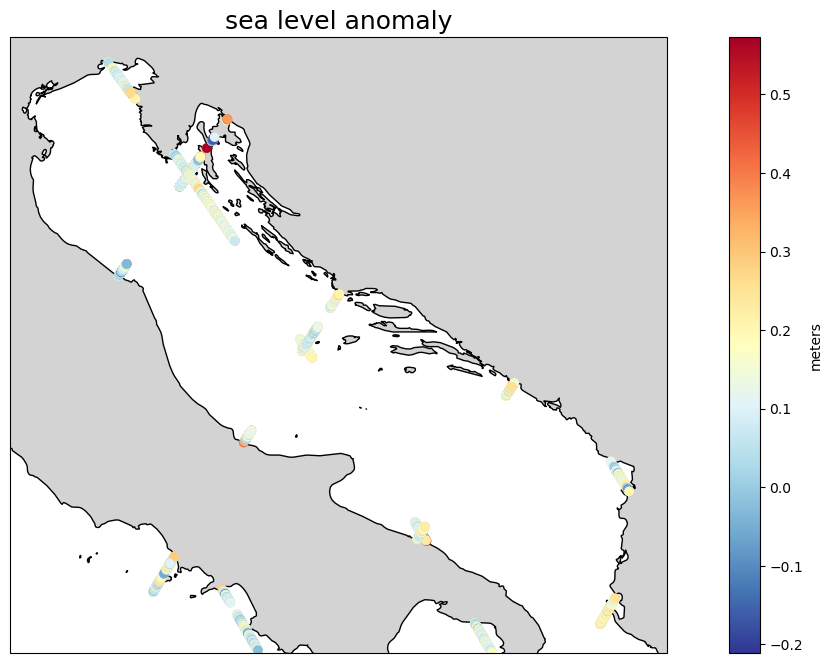

In [10]:
distance = 15*1000 # distance in the data is in meters
dist_coast = subsetArea['distance_from_coast']
subsetAreadist = subsetArea.sel(time=(dist_coast<=distance))

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
#ax.set_extent([-6, 0,  lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)

# plot the data on a map (again sea level anomaly
tracks = ax.scatter(subsetAreadist['longitude'], subsetAreadist['latitude'], c=subsetAreadist['sea_level_anomaly'], cmap='RdYlBu_r', marker='o')
cbar = plt.colorbar(tracks)
cbar.set_label('meters')
plt.title('sea level anomaly', size=18)
plt.show()


Select a given track using the whole area (note that you will have the same track several times within a full month using Jason-3; only the latest will be visible on the map - we'll see later a way to discriminate between them)

See https://www.aviso.altimetry.fr/en/data/tools/pass-locator.html to determine track number(s).

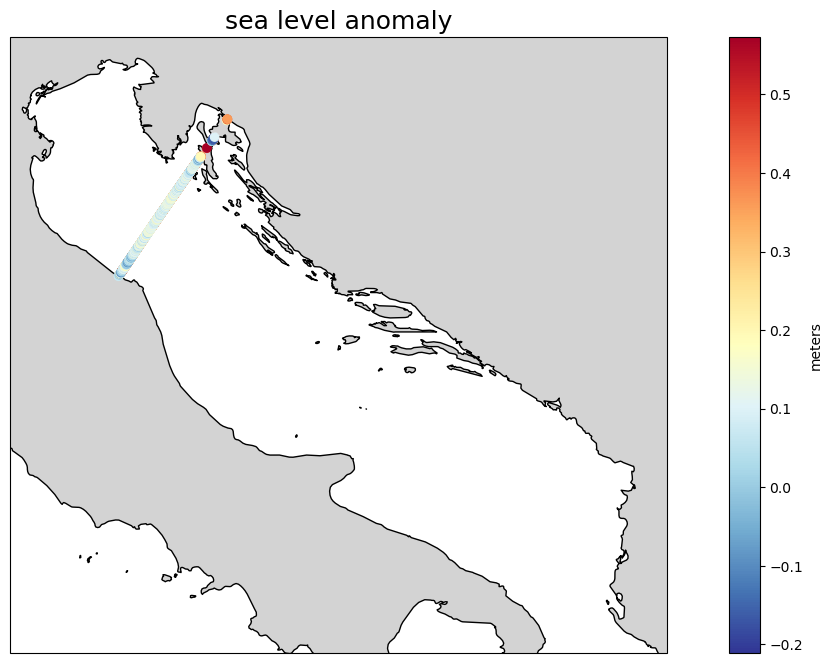

In [11]:
# the track crossing the Northern Adriatic sea 
mytrack = 161
subsetByTrack = subsetArea.sel(time=(subsetArea.track==mytrack))

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
#ax.set_extent([-6, 0,  lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# plot the data on a map
tracks = ax.scatter(subsetByTrack['longitude'], subsetByTrack['latitude'], c=subsetByTrack['sea_level_anomaly'], cmap='RdYlBu_r', marker='o')
cbar = plt.colorbar(tracks)
cbar.set_label('meters')
plt.title('sea level anomaly', size=18)
plt.show()

Now we will group the data by cycles - this can be useful to work on different dates if you have several data at the same locations as in our aggregated monthly file.

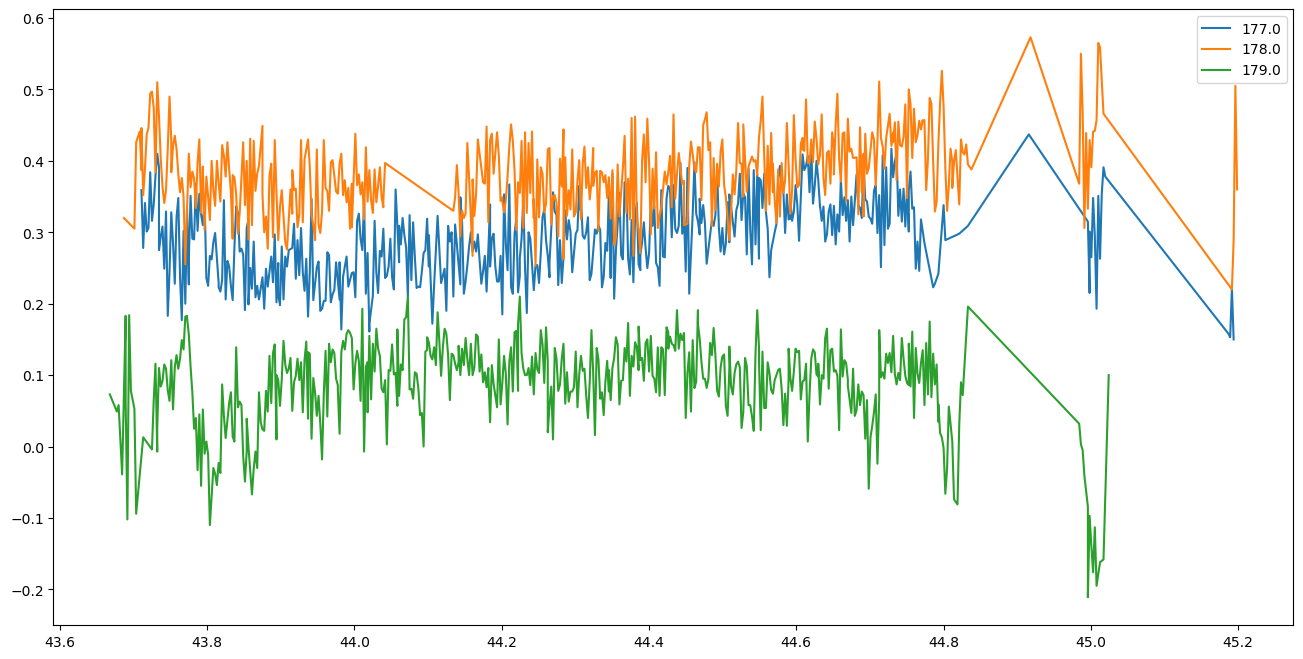

In [83]:
cycle_nb = subsetByTrack['cycle'] 
groupeddata = subsetByTrack.groupby('cycle')
#list(subsetArea.groupby('cycle'))
fig = plt.figure(figsize=(16,8))
for cycle, subsetByTrackbycycle in groupeddata:
    lat = subsetByTrackbycycle['latitude_theoretical']
    sla = subsetByTrackbycycle['sea_level_anomaly']
    plt.plot(lat, sla, label=cycle)
plt.legend(loc='best')
plt.show()

The same track show noticeable different sea level anomalies at only 10 days interval (about 40-50 cm) - tides, or atmospheric low pressure are taken into account in the SLA corrections ; it could be interesting to look at them for coastal flooding hazards, since they will contribute if any. 

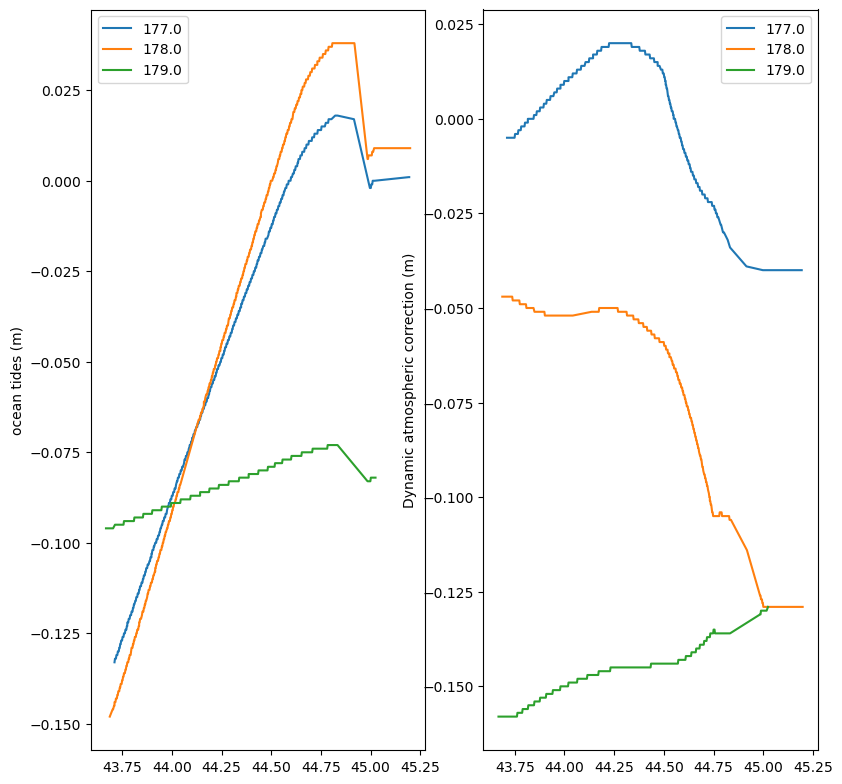

In [12]:
cycle_nb = subsetByTrack['cycle'] 
groupeddata = subsetByTrack.groupby('cycle')
#list(subsetArea.groupby('cycle'))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
fig.tight_layout()

for cycle, subsetByTrackbycycle in groupeddata:
    lat = subsetByTrackbycycle['latitude_theoretical']
    dac = subsetByTrackbycycle['dac']
    octide = subsetByTrackbycycle['ocean_tide']
    axes[0].plot(lat, octide, label=cycle)
    axes[1].plot(lat, dac, label=cycle)
axes[0].legend(loc='best')
axes[0].set_ylabel('ocean tides (m)')
axes[1].legend(loc='best')
axes[1].set_ylabel('Dynamic atmospheric correction (m)')
plt.show()